In [2]:
import os, glob, subprocess, datetime

import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import properscoring as ps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scores import *
from sklearn.neighbors import KernelDensity
from scipy.integrate import quad
from scipy import interpolate
from ipywidgets import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from scipy.stats import multivariate_normal, norm
from scipy.interpolate import make_smoothing_spline

path_to_fPCA   = '/Users/Guille/Desktop/dynamic_update/software/fPCA'
path_to_fDepth = '/Users/Guille/Desktop/dynamic_update/software/fDepth'
path_to_data   = '/Users/Guille/Desktop/dynamic_update/data'

In [3]:
# Resource
resource = 'wind'

# Asset index
i_asset = 10

# Time Zone
T_zone = 24

ac_ = pd.read_csv(path_to_data + '/actuals/' + resource + '_actual_5min_site_2017.csv')
print(ac_.columns[i_asset + 1])

dates_    = ac_[['Time']].to_numpy()[T_zone*12:]
ac_       = ac_[[ac_.columns[i_asset + 1]]].to_numpy()[T_zone*12:]
ac_tr_    = ac_.reshape(int(ac_.shape[0]/288), 288)[:-1, :]
dates_tr_ = dates_.reshape(int(dates_.shape[0]/288), 288)[:-1, :]
print(ac_tr_.shape, dates_tr_.shape)

ac_ = pd.read_csv(path_to_data + '/actuals/' + resource + '_actual_5min_site_2018.csv')
print(ac_.columns[i_asset + 1])

dates_    = ac_[['Time']].to_numpy()[T_zone*12:]
ac_       = ac_[[ac_.columns[i_asset + 1]]].to_numpy()[T_zone*12:]
ac_ts_    = ac_.reshape(int(ac_.shape[0]/288), 288)[:-1, :]
dates_ts_ = dates_.reshape(int(dates_.shape[0]/288), 288)[:-1, :]
print(ac_ts_.shape, dates_ts_.shape)

Baffin
(363, 288) (363, 288)
Baffin
(363, 288) (363, 288)


In [4]:
# Time Zone
T_zone = 17

fc_ = pd.read_csv(path_to_data + '/actuals/' + resource + '_day_ahead_forecast_2018.csv')
print(fc_.columns[i_asset + 3])

fc_ = fc_[[fc_.columns[i_asset + 3]]].to_numpy()[T_zone:-(24 - T_zone)][:, 0]
print(fc_.shape)

x_ac_ = np.linspace(0, ac_.shape[0] - 1, ac_.shape[0], dtype = int)[:-11]
x_fc_ = np.linspace(0, fc_.shape[0] - 1, fc_.shape[0], dtype = int)*12
print(x_ac_.shape)
print(x_fc_.shape)

fc_ts_ = interpolate.interp1d(x_fc_, fc_, kind = 'linear')(x_ac_)
fc_ts_ = fc_ts_[:-277]
fc_ts_ = fc_ts_.reshape(int(fc_ts_.shape[0]/288), 288)
print(fc_ts_.shape)

Baffin
(8736,)
(104821,)
(8736,)
(363, 288)


In [8]:
def _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.6, f_min = 0, f_max = 1):
    
    s_ts_hat_  = np.sqrt(np.diagonal(S_ts_hat_))
    f_ts_upper = f_ts_hat_ + z*s_ts_hat_
    f_ts_lower = f_ts_hat_ - z*s_ts_hat_
    
    f_ts_lower = _gen_constraint(f_ts_lower, f_min, f_max)
    f_ts_upper = _gen_constraint(f_ts_upper, f_min, f_max)

    return f_ts_upper, f_ts_lower

def _plot_results(F_tr_, F_ts_scen_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_, dates_, i_day, t_event):
    

    plt.figure(figsize = (10, 2.5))
    plt.title('{}'.format(dates_[i_day, t_event]))

    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 2.25, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .1, label = '97.5% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.96, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .15, label = '95% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.65, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .2, label = '90% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 1.28, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .25, label = '80% (ci)')
    f_ts_lower, f_ts_upper = _predictive_intervals(f_ts_hat_, S_ts_hat_, z = 0.84, f_min = F_tr_.min(), f_max = F_tr_.max())
    plt.fill_between(t_ts_, f_ts_lower, f_ts_upper, color = 'gray', alpha = .3, label = '60% (ci)')

    plt.plot(t_ts_, F_ts_scen_.T, c = 'k', lw = 0.25, alpha = 0.25)
    plt.plot(t_ts_, F_ts_scen_[0, :], c = 'k', lw = 0.25, label = 'sc (pred)', alpha = 0.25)
    
    plt.plot(t_tr_, f_tr_, c = 'k', label = 'ac (obv)')
    plt.plot(t_ts_, f_ts_, c = 'red', label = 'ac (unobv)')
    plt.plot(t_tr_, fct_tr_, c = 'blue')
    plt.plot(t_ts_, fct_ts_, c = 'blue', label = 'fc (obv)')
    plt.plot(t_ts_, f_ts_hat_, color = 'green', label = 'fc (update)')
    
    plt.axvline(t_ts_[0], lw = 2, c = 'lime', label = 'event')

    # plt.ylim(F_tr_.min(), F_tr_.max())
    # plt.xlim(0, 287)
    #plt.legend(frameon = False, ncol = 6)
    plt.xticks(np.concatenate([t_tr_, t_ts_], axis = 0)[::12], 
                              [datetime.datetime.fromisoformat(date).strftime('%H:%M') for date in dates_[i_day, ::12]], rotation = 45)

    plt.show()
    
def _test_sample(ac_tr_, ac_ts_, fc_ts_, dates_, i_day, t_event, viz = True):
    
    t_ = np.linspace(0, ac_ts_.shape[1] - 1, ac_ts_.shape[1], dtype = int)
    #print(t_.shape, ac_ts_.shape)

    date_ = dates_[i_day, :]

    t_ts_ = t_[t_event:]
    t_tr_ = t_[:t_event]

    f_    = ac_ts_[i_day, :]
    f_tr_ = ac_ts_[i_day, :t_event]
    f_ts_ = ac_ts_[i_day, t_event:]
    #print(f_.shape, f_tr_.shape, f_ts_.shape)

    F_    = ac_tr_
    F_tr_ = ac_tr_[:, :t_event]
    F_ts_ = ac_tr_[:, t_event:]
    #print(F_.shape, F_tr_.shape, F_ts_.shape)

    fct_    = fc_ts_[i_day, :]
    fct_tr_ = fc_ts_[i_day, :t_event]
    fct_ts_ = fc_ts_[i_day, t_event:]
    #print(fct_.shape, fct_tr_.shape, fct_ts_.shape)
    
    if viz:
        plt.figure(figsize = (10, 2))
        plt.title('{}'.format(dates_[i_day, t_event]))

        plt.plot(t_tr_, F_tr_.T, color = 'gray', lw = 0.1)
        plt.plot(t_ts_, F_ts_.T, color = 'k', lw = 0.1)
        plt.plot(t_, F_[0, :], color = 'k', lw = 0.1, label = 'sc (obv)')
        plt.plot(t_tr_, f_tr_, c = 'red')
        plt.plot(t_ts_, f_ts_, c = 'red', ls = '--', label = 'ac (unobv)')
        plt.plot(t_, fct_, c = 'blue')
        plt.plot(t_ts_, fct_ts_, c = 'blue', label = 'fc (obv)')
        plt.axvline(t_[t_event - 1], lw = 2, c = 'lime', label = 'event')
        plt.xticks(t_[::12], 
                   [datetime.datetime.fromisoformat(date).strftime('%H:%M') for date in dates_[i_day, ::12]], rotation = 45)

        plt.legend()
        plt.show()

    return F_tr_, F_ts_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_


In [9]:
def _gen_constraint(f_, f_min, f_max):
    f_[f_ < f_min] = f_min
    f_[f_ > f_max] = f_max
    return f_

def _update_rate(N, update_rate = 1):
    x_ = np.linspace(0, N - 1, N)
    if update_rate == 0:
        w_ = np.ones((N,))
    else:
        w_ = np.exp(-x_/update_rate)
    return x_, w_

def _forget_rate(N, forget_rate = 1):
    x_ = np.linspace(0, N - 1, N)
    if forget_rate == 0:
        w_ = np.ones((N,))
    else:
        w_ = np.exp(-x_/forget_rate)

    return x_, w_[::-1]

def _dist(X_, x_, w_):
    d_ = np.zeros((X_.shape[0], ))
    for i in range(X_.shape[0]):
        d_[i] = w_.T @ (X_[i, :] - x_)**2
    return d_

def _kernel(d_, length_scale):
    w_ = np.exp(-d_/length_scale)
    return w_/w_.sum()

def _smoothing(F_, f_, lamdba):
    
    if bool(lamdba):
        x_        = np.linspace(0, f_.shape[0] - 1, f_.shape[0])
        F_smooth_ = F_.copy()
        f_smooth_ = make_smoothing_spline(x_, f_, lam = lamdba)(x_)
        for i in range(F_.shape[0]):
            F_smooth_[i, :] = make_smoothing_spline(x_, F_[i, :], lam = lamdba)(x_)
        F_ = F_smooth_.copy()
        f_ = f_smooth_.copy()
    
    return F_, f_

# Fuse day-ahead forecast with real-time forecast
def _update_forecast(F_ac_, f_hat_, f_fc_, update_rate, viz = False):
    if bool(update_rate):
        z_, eta_  = _update_rate(F_ac_.shape[1], update_rate = update_rate)
        w_        = 1. - eta_/eta_.max()
        f_update_ = f_hat_*(1. - w_) + f_fc_*w_

        if viz:
            plt.figure(figsize = (10, 2))
            plt.title('Update Rate')
            plt.plot(z_, w_)
            plt.ylim(-0.1,1.1)
            plt.show()

            plt.figure(figsize = (10, 2))
            plt.plot(f_hat_, label = 'real-time (fc)')
            plt.plot(f_fc_, label = 'day-ahead (fc)')
            plt.plot(f_update_, label = 'update (fc)')
            plt.ylim(-0.1,)
            plt.legend()
            plt.show()

        return f_update_.copy()
    else:
        return f_fc_

In [10]:
# def _ffc(F_, f_, F_ac_, f_fc_, forget_rate  = 1,
#                                update_rate  = 0,
#                                length_scale = 100, 
#                                lamdba       = 0,
#                                smoothing    = 0,
#                                N_scen       = 100, 
#                                viz          = True):
    
#     f_min = F_.min()
#     f_max = F_.max()
    
#     # Smoothing observed mean and actuals
#     if (smoothing == 0) | (smoothing == 2): 
#         F_, f_ = _smoothing(F_, f_, lamdba)

#     # Calculate forget rate
#     z_, phi_ = _forget_rate(f_.shape[0], forget_rate)
#     w_       = phi_/phi_.sum()

#     if viz:
#         plt.figure(figsize = (10, 2))
#         plt.title('Forgeting rate')
#         plt.plot(z_, phi_)
#         plt.ylim(-0.1,)
#         plt.show()
    
#     d_ = _dist(F_, f_, w_)
#     w_ = _kernel(d_, length_scale = length_scale)
#     x_ = np.linspace(0, w_.shape[0] - 1, w_.shape[0])

#     if viz:
#         plt.figure(figsize = (10, 2))
#         plt.title('Samples Weights')
#         plt.plot(x_, w_)
#         plt.show()
        
#         _cmap = plt.get_cmap('inferno')
#         _norm = plt.Normalize(w_.min(), w_.max())
#         c_    = _cmap(_norm(w_))
#         idx_  = np.argsort(w_)
        
#         plt.figure(figsize = (10, 2))
#         for i in range(w_.shape[0]):
#             plt.plot(np.arange(F_.shape[1]), F_[idx_[i], :], c  = c_[idx_[i], :], 
#                                                              lw = 1)
#             plt.plot(np.arange(F_ac_.shape[1]) + F_.shape[1], F_ac_[idx_[i], :], c  = c_[idx_[i], :], 
#                                                                                  lw = 1)
#         plt.axvline(F_.shape[1], c  = 'lime', 
#                                  lw = 2.5)
#         plt.show
        
#     # Mean function
#     f_hat_ = F_ac_.T @ w_ 
    
#     # Fuse day-ahead forecast with real-time forecast
#     f_hat_ = _update_forecast(F_ac_, f_hat_, f_fc_, update_rate, viz = viz)
    
#     # Smoothing unobserved mean and actuals
#     if (smoothing == 1) | (smoothing == 2): 
#         F_ac_, f_hat_ = _smoothing(F_ac_, f_hat_, lamdba)
    
#     # Covariance Function
#     F_hat_ = np.repeat(f_hat_[:, np.newaxis], F_ac_.shape[0], axis = 1).T
#     S_hat_ = (F_ac_ - F_hat_).T @ np.diag(w_) @ (F_ac_ - F_hat_)
    
#     # Generate predictive scenarios
#     F_scen_ = multivariate_normal(f_hat_, S_hat_, allow_singular = True).rvs(N_scen)
#     F_scen_ = _gen_constraint(F_scen_, f_min, f_max)
    
#     # Regularize Mean and Scenarios
#     #f_hat_  = _gen_constraint(f_hat_, f_min, f_max)
#     F_scen_ = _gen_constraint(F_scen_, f_min, f_max)

#     return f_hat_, S_hat_, F_scen_


# def _fknn_fc(F_, f_, F_ac_, f_fc_, forget_rate  = 1,
#                                    update_rate  = 0,
#                                    length_scale = 100, 
#                                    lamdba       = 1, 
#                                    smoothing    = 0,
#                                    k            = 0,
#                                    prob          = 0.01,
#                                    k_min        = 5,
#                                    k_max        = 50,
#                                    N_scen       = 1, 
#                                    uniform      = False,
#                                    viz          = False):

#     f_min = F_.min()
#     f_max = F_.max()
    
#     # Smoothing observed mean and actuals
#     if (smoothing == 0) | (smoothing == 2): 
#         F_, f_ = _smoothing(F_, f_, lamdba)
    
#     # Calculate forget rate
#     y_, phi_ = _forget_rate(f_.shape[0], forget_rate)
#     w_       = phi_/phi_.sum()

#     # Calculate distance between samples
#     d_ = _dist(F_, f_, w_)
#     w_ = _kernel(d_, length_scale = length_scale)
#     x_ = np.linspace(0, w_.shape[0] - 1, w_.shape[0])
        
#     # k-Nearest Neibors
#     if k == 0:
        
#         i = int(np.sum(np.cumsum(np.sort(w_)[::-1]) < prob))
#         idx_ = w_ > np.sort(w_)[::-1][i]
#         if (idx_.sum() < k_min):
#             idx_ = w_ > np.sort(w_)[-k_min - 1]
#         if (idx_.sum() > k_max):
#             idx_ = w_ > np.sort(w_)[-k_max - 1]      
#     else:
#         k    += 1
#         idx_ = w_.argsort().argsort() > w_.shape[0] - k
#         prob = w_[idx_].min()

#     if viz:
#         plt.figure(figsize = (10, 2))
#         plt.plot(x_, np.cumsum(np.sort(w_)[::-1]))
#         plt.axhline(prob, c  = 'red', 
#                          ls = '--')
#         plt.axvline(idx_.sum() - 1, c  = 'red', 
#                          ls = '--')
#         plt.ylim(0,)
#         plt.xlim(0, x_.shape[0] - 1)
#         plt.show()

#         plt.figure(figsize = (10, 2))
#         plt.title('Weights - {} Selected samples'.format(idx_.sum()))
#         plt.bar(x_, w_)
#         plt.plot(x_[idx_], w_[idx_], '.', c = 'red', ms = 2.5)
#         plt.ylim(0,)
#         plt.xlim(0, x_.shape[0] - 1)

#         plt.show()
        
#     F_knn_ac_ = F_ac_[idx_, :]
#     w_knn_    = w_[idx_]/w_[idx_].sum()

#     if uniform:
#         w_knn_ = np.ones((w_knn_.shape[0],))/w_knn_.shape[0]

#         if viz:
#             plt.figure(figsize = (10, 2))
#             plt.plot(np.arange(F_.shape[1]), F_[idx_, :].T, c = 'k')
#             plt.plot(np.arange(F_ac_.shape[1]) + F_.shape[1], F_knn_ac_.T, c = 'gray')
#             plt.axvline(F_.shape[1], c  = 'lime', 
#                                      lw = 2.5, 
#                                      ls = '--')
#             plt.show()
            
#     else:
#         _cmap = plt.get_cmap('inferno')
#         _norm = plt.Normalize(w_knn_.min(), w_knn_.max())
#         c_    = _cmap(_norm(w_knn_))
            
#         if viz:
#             plt.figure(figsize = (10, 2))
#             plt.plot(np.arange(F_.shape[1]), F_[idx_, :].T, c = 'k')
#             idx_ = np.argsort(w_knn_)
#             for i in range(idx_.shape[0]):
#                 plt.plot(np.arange(F_ac_.shape[1]) + F_.shape[1], F_knn_ac_[idx_[i], :], c = c_[idx_[i], :])  
#             plt.axvline(F_.shape[1], c  = 'lime', 
#                                      lw = 2.5, 
#                                      ls = '--')
#             plt.xlim(0, 287)
#             plt.ylim(0, )

#             plt.show()
        
#     # Mean function
#     f_hat_ = F_knn_ac_.T @ w_knn_   

#     # Fuse day-ahead forecast with real-time forecast
#     f_hat_ = _update_forecast(F_ac_, f_hat_, f_fc_, update_rate, viz)
    
#     # Smoothing unobserved mean and actuals
#     if (smoothing == 1) | (smoothing == 2): 
#         F_ac_, f_hat_ = _smoothing(F_ac_, f_hat_, lamdba)

#     # Covariance Function
#     F_hat_ = np.repeat(f_hat_[:, np.newaxis], F_knn_ac_.shape[0], axis = 1).T
#     S_hat_ = (F_knn_ac_ - F_hat_).T @ np.diag(w_knn_) @ (F_knn_ac_ - F_hat_)
    
#     F_scen_ = multivariate_normal(f_hat_, S_hat_, allow_singular = True).rvs(N_scen)
#     F_scen_ = _gen_constraint(F_scen_, f_min, f_max)

#     # Regularize Mean and Scenarios
#     #f_hat_  = _gen_constraint(f_hat_, f_min, f_max)
#     F_scen_ = _gen_constraint(F_scen_, f_min, f_max)

#     return f_hat_, S_hat_, F_scen_


f _ffc(F_, f_, F_ac_, f_fc_, forget_rate  = 1,
                               update_rate  = 0,
                               length_scale = 100, 
                               lamdba       = 0,
                               smoothing    = 0,
                               N_scen       = 100, 
                               viz          = True):
    
    f_min = F_.min()
    f_max = F_.max()
    
    # Smoothing observed mean and actuals
    if (smoothing == 0) | (smoothing == 2): 
        F_, f_ = _smoothing(F_, f_, lamdba)

    # Calculate forget rate
    z_, phi_ = _forget_rate(f_.shape[0], forget_rate)
    w_       = phi_/phi_.sum()

    if viz:
        plt.figure(figsize = (10, 2))
        plt.title('Forgeting rate')
        plt.plot(z_, phi_)
        plt.ylim(-0.1,)
        plt.show()
    
    d_ = _dist(F_, f_, w_)
    w_ = _kernel(d_, length_scale = length_scale)
    x_ = np.linspace(0, w_.shape[0] - 1, w_.shape[0])

    if viz:
        plt.figure(figsize = (10, 2))
        plt.title('Samples Weights')
        plt.plot(x_, w_)
        plt.show()
        
        _cmap = plt.get_cmap('inferno')
        _norm = plt.Normalize(w_.min(), w_.max())
        c_    = _cmap(_norm(w_))
        idx_  = np.argsort(w_)
        
        plt.figure(figsize = (10, 2))
        for i in range(w_.shape[0]):
            plt.plot(np.arange(F_.shape[1]), F_[idx_[i], :], c  = c_[idx_[i], :], 
                                                             lw = 1)
            plt.plot(np.arange(F_ac_.shape[1]) + F_.shape[1], F_ac_[idx_[i], :], c  = c_[idx_[i], :], 
                                                                                 lw = 1)
        plt.axvline(F_.shape[1], c  = 'lime', 
                                 lw = 2.5)
        plt.show
        
    # Mean function
    f_hat_ = F_ac_.T @ w_ 
    
    # Fuse day-ahead forecast with real-time forecast
    f_hat_ = _update_forecast(F_ac_, f_hat_, f_fc_, update_rate, viz = viz)
    
    # Smoothing unobserved mean and actuals
    if (smoothing == 1) | (smoothing == 2): 
        F_ac_, f_hat_ = _smoothing(F_ac_, f_hat_, lamdba)
    
    # Covariance Function
    F_hat_ = np.repeat(f_hat_[:, np.newaxis], F_ac_.shape[0], axis = 1).T
    S_hat_ = (F_ac_ - F_hat_).T @ np.diag(w_) @ (F_ac_ - F_hat_)
    
    # Generate predictive scenarios
    F_scen_ = multivariate_normal(f_hat_, S_hat_, allow_singular = True).rvs(N_scen)
    F_scen_ = _gen_constraint(F_scen_, f_min, f_max)
    
    # Regularize Mean and Scenarios
    #f_hat_  = _gen_constraint(f_hat_, f_min, f_max)
    F_scen_ = _gen_constraint(F_scen_, f_min, f_max)

    return f_hat_, S_hat_, F_scen_


def _fknn_fc_fit(F_, F_ac_, f_fc_, forget_rate  = 1,
                                   update_rate  = 0,
                                   length_scale = 100, 
                                   lamdba       = 1, 
                                   smoothing    = 0,
                                   k            = 0,
                                   prob         = 0.01,
                                   k_min        = 5,
                                   k_max        = 50,
                                   N_scen       = 1, 
                                   uniform      = False,
                                   viz          = False):
    
    fknn_fc_          = {}
    fknn_fc_['f_min'] = F_.min()
    fknn_fc_['f_max'] = F_.max()
    fknn_fc_['F_tr_'] = F_.copy()
    fknn_fc_['F_ts_'] = F_.copy()

    # Smoothing observed mean and actuals
    if (smoothing == 0) | (smoothing == 2): 
        F_, f_ = _smoothing(F_, f_, lamdba)
    
    # Calculate forget rate
    y_, phi_ = _forget_rate(f_.shape[0], forget_rate)
    w_       = phi_/phi_.sum()

    # Calculate distance between samples
    d_ = _dist(F_, f_, w_)
    w_ = _kernel(d_, length_scale = length_scale)
    x_ = np.linspace(0, w_.shape[0] - 1, w_.shape[0])
        
    # k-Nearest Neibors
    if k == 0:
        
        i = int(np.sum(np.cumsum(np.sort(w_)[::-1]) < prob))
        idx_ = w_ > np.sort(w_)[::-1][i]
        if (idx_.sum() < k_min):
            idx_ = w_ > np.sort(w_)[-k_min - 1]
        if (idx_.sum() > k_max):
            idx_ = w_ > np.sort(w_)[-k_max - 1]      
    else:
        k    += 1
        idx_ = w_.argsort().argsort() > w_.shape[0] - k
        prob = w_[idx_].min()

    if viz:
        plt.figure(figsize = (10, 2))
        plt.plot(x_, np.cumsum(np.sort(w_)[::-1]))
        plt.axhline(prob, c  = 'red', 
                         ls = '--')
        plt.axvline(idx_.sum() - 1, c  = 'red', 
                         ls = '--')
        plt.ylim(0,)
        plt.xlim(0, x_.shape[0] - 1)
        plt.show()

        plt.figure(figsize = (10, 2))
        plt.title('Weights - {} Selected samples'.format(idx_.sum()))
        plt.bar(x_, w_)
        plt.plot(x_[idx_], w_[idx_], '.', c = 'red', ms = 2.5)
        plt.ylim(0,)
        plt.xlim(0, x_.shape[0] - 1)

        plt.show()
        
    F_knn_ac_ = F_ac_[idx_, :]
    w_knn_    = w_[idx_]/w_[idx_].sum()

    if uniform:
        w_knn_ = np.ones((w_knn_.shape[0],))/w_knn_.shape[0]

        if viz:
            plt.figure(figsize = (10, 2))
            plt.plot(np.arange(F_.shape[1]), F_[idx_, :].T, c = 'k')
            plt.plot(np.arange(F_ac_.shape[1]) + F_.shape[1], F_knn_ac_.T, c = 'gray')
            plt.axvline(F_.shape[1], c  = 'lime', 
                                     lw = 2.5, 
                                     ls = '--')
            plt.show()
            
    else:
        _cmap = plt.get_cmap('inferno')
        _norm = plt.Normalize(w_knn_.min(), w_knn_.max())
        c_    = _cmap(_norm(w_knn_))
            
        if viz:
            plt.figure(figsize = (10, 2))
            plt.plot(np.arange(F_.shape[1]), F_[idx_, :].T, c = 'k')
            idx_ = np.argsort(w_knn_)
            for i in range(idx_.shape[0]):
                plt.plot(np.arange(F_ac_.shape[1]) + F_.shape[1], F_knn_ac_[idx_[i], :], c = c_[idx_[i], :])  
            plt.axvline(F_.shape[1], c  = 'lime', 
                                     lw = 2.5, 
                                     ls = '--')
            plt.xlim(0, 287)
            plt.ylim(0, )

            plt.show()
        
    # Mean function
    f_hat_ = F_knn_ac_.T @ w_knn_   

    # Fuse day-ahead forecast with real-time forecast
    f_hat_ = _update_forecast(F_ac_, f_hat_, f_fc_, update_rate, viz)
    
    # Smoothing unobserved mean and actuals
    if (smoothing == 1) | (smoothing == 2): 
        F_ac_, f_hat_ = _smoothing(F_ac_, f_hat_, lamdba)

    # Covariance Function
    F_hat_ = np.repeat(f_hat_[:, np.newaxis], F_knn_ac_.shape[0], axis = 1).T
    S_hat_ = (F_knn_ac_ - F_hat_).T @ np.diag(w_knn_) @ (F_knn_ac_ - F_hat_)
    
    F_scen_ = multivariate_normal(f_hat_, S_hat_, allow_singular = True).rvs(N_scen)
    F_scen_ = _gen_constraint(F_scen_, f_min, f_max)

    # Regularize Mean and Scenarios
    #f_hat_  = _gen_constraint(f_hat_, f_min, f_max)
    F_scen_ = _gen_constraint(F_scen_, f_min, f_max)

    return f_hat_, S_hat_, F_scen_



f_ts_hat_, S_ts_hat_, F_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                         forget_rate  = 1, 
                                         update_rate  = 200,
                                         k            = 0,
                                         prob         = 0.90,
                                         uniform      = False,
                                         length_scale = 100,
                                         lamdba       = 0,
                                         smoothing    = 0,
                                         N_scen       = 100,
                                         viz          = True)

SyntaxError: invalid syntax (2083219563.py, line 198)

In [12]:
yearday  = 50
interval = 140

F_tr_, F_ts_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_ = _test_sample(ac_tr_, ac_ts_, fc_ts_, dates_ts_,
                                                                          i_day   = yearday, 
                                                                          t_event = interval,
                                                                          viz     = False)

print(F_tr_.shape, f_tr_.shape, F_ts_.shape, fct_ts_.shape)

(363, 140) (140,) (363, 148) (148,)


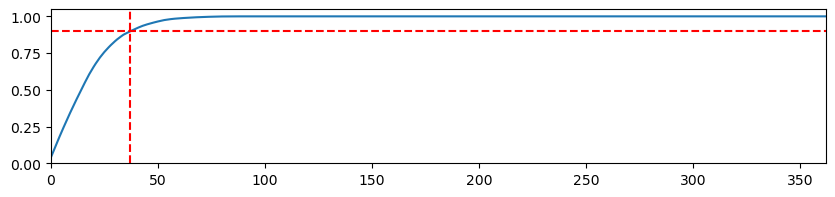

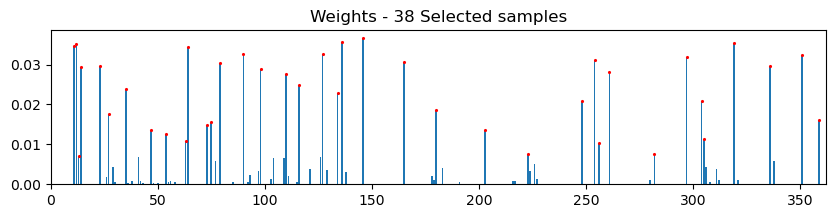

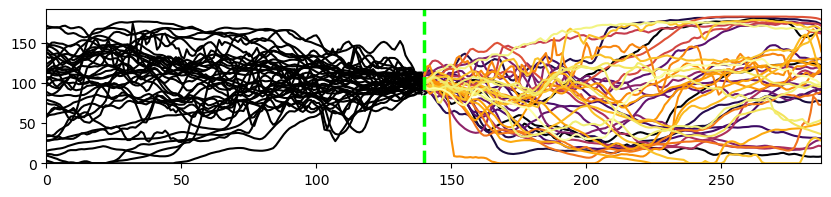

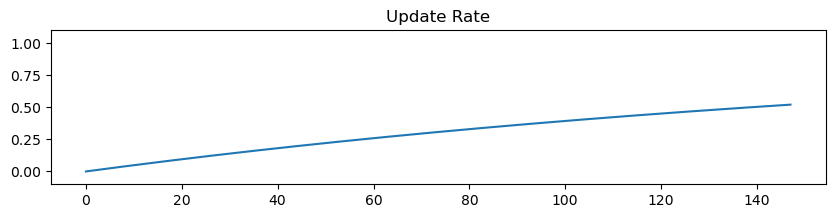

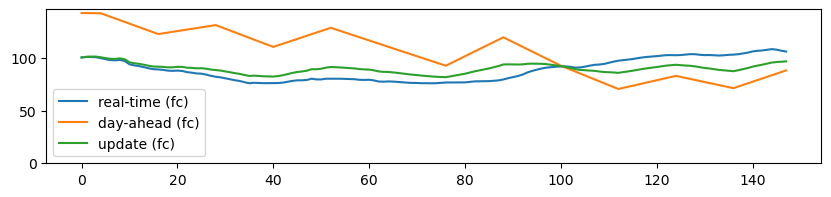

In [6]:



f_ts_hat_, S_ts_hat_, F_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                         forget_rate  = 1, 
                                         update_rate  = 200,
                                         k            = 0,
                                         prob         = 0.90,
                                         uniform      = False,
                                         length_scale = 100,
                                         lamdba       = 0,
                                         smoothing    = 0,
                                         N_scen       = 100,
                                         viz          = True)

# f_ts_hat_, S_ts_hat_, F_ts_scen_ = _ffc(F_tr_, f_tr_, F_ts_, fct_ts_,
#                                         forget_rate  = 0, 
#                                         update_rate  = 0, 
#                                         length_scale = 90,
#                                         lamdba       = 0,
#                                         smoothing    = 0,
#                                         N_scen       = 100, 
#                                         viz          = True)



0 124


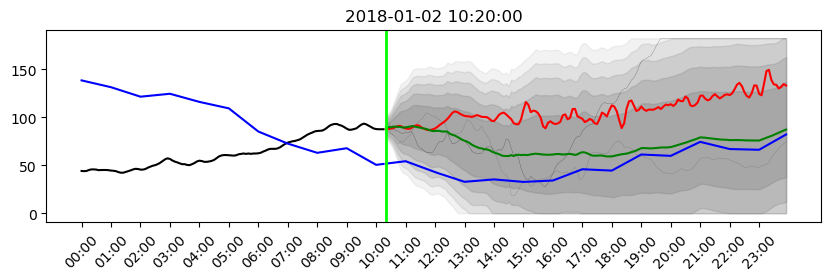

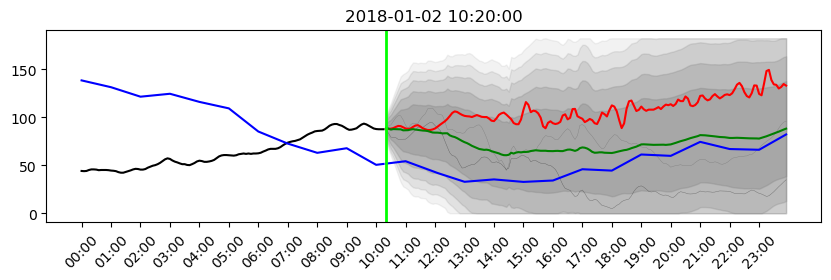

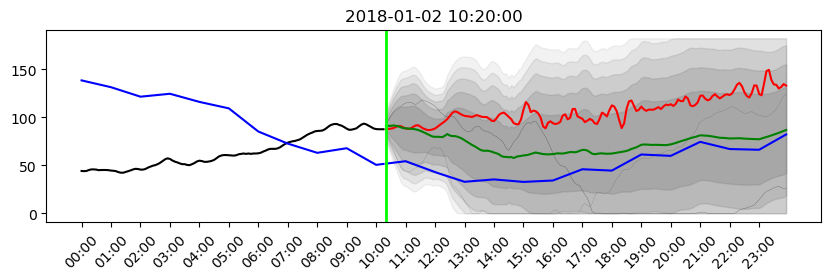

90 124


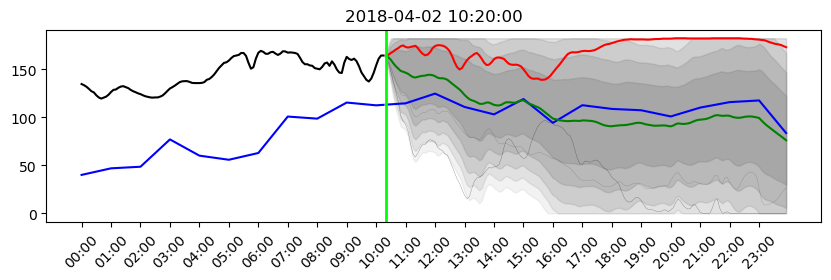

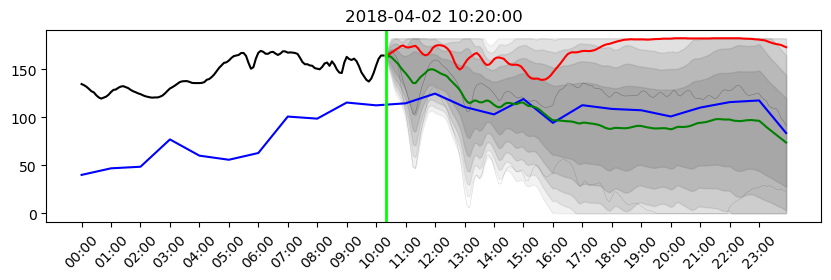

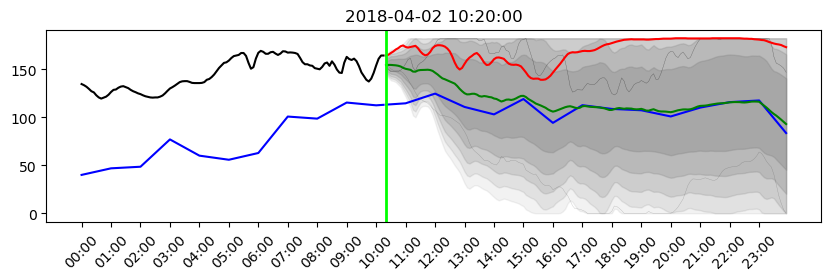

180 124


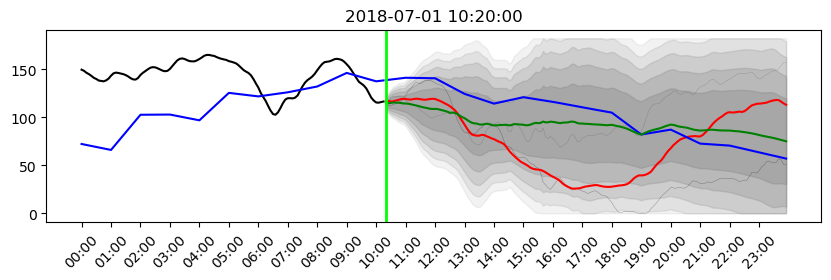

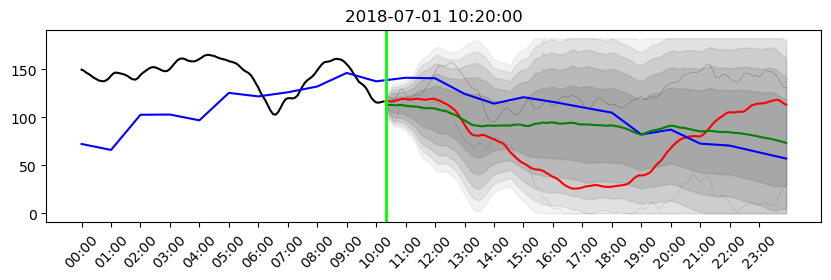

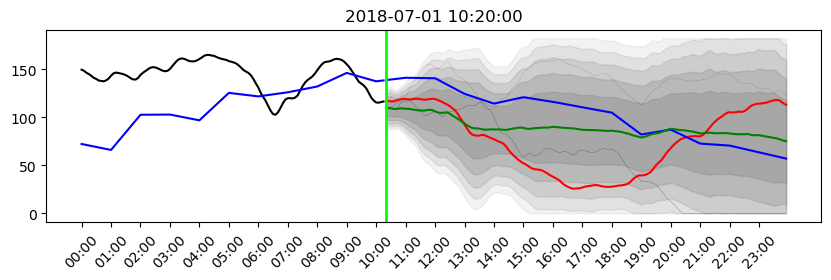

270 124


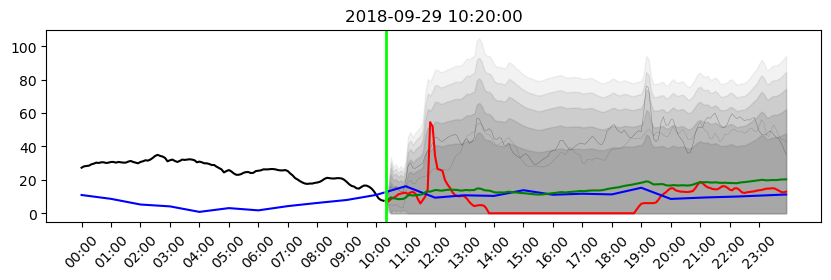

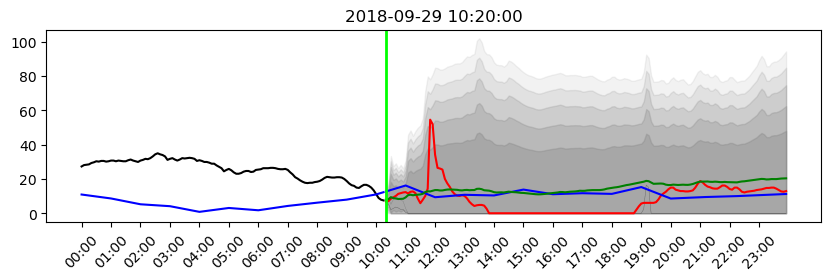

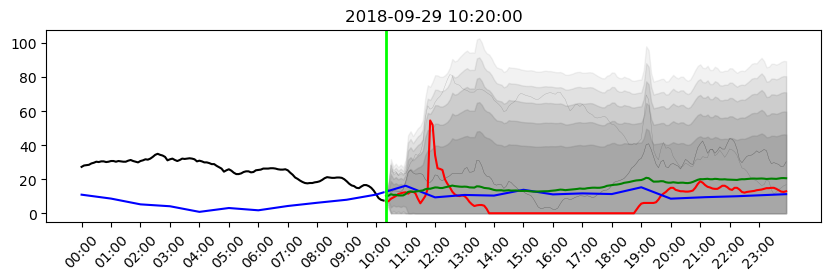

In [7]:
interval = 124

for yearday in range(0, 360, 90):
    print(yearday, interval)

    F_tr_, F_ts_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_ = _test_sample(ac_tr_, ac_ts_, fc_ts_, dates_ts_,
                                                                              i_day   = yearday, 
                                                                              t_event = interval,
                                                                              viz     = False)

    f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                forget_rate  = 1, 
                                                update_rate  = 150,
                                                prob         = 0.9,
                                                length_scale = 25,
                                                smoothing    = 0,
                                                lamdba       = 0,
                                                N_scen       = 2,
                                                viz          = False)

    _plot_results(F_tr_, F_ts_scen_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_, dates_ts_, 
                  i_day   = yearday, 
                  t_event = interval)
    
    f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                forget_rate  = 1, 
                                                update_rate  = 150,
                                                prob         = 0.9,
                                                length_scale = 25,
                                                smoothing    = 0,
                                                lamdba       = 10,
                                                N_scen       = 2,
                                                viz          = False)

    _plot_results(F_tr_, F_ts_scen_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_, dates_ts_, 
                  i_day   = yearday, 
                  t_event = interval)
    
    f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                forget_rate  = 1, 
                                                update_rate  = 150,
                                                prob         = 0.9,
                                                length_scale = 25,
                                                smoothing    = 0,
                                                lamdba       = 1000,
                                                N_scen       = 2,
                                                viz          = False)

    _plot_results(F_tr_, F_ts_scen_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_, dates_ts_, 
                  i_day   = yearday, 
                  t_event = interval)

(164,) (164, 164) (2, 164)


ValueError: operands could not be broadcast together with shapes (240,) (164,) 

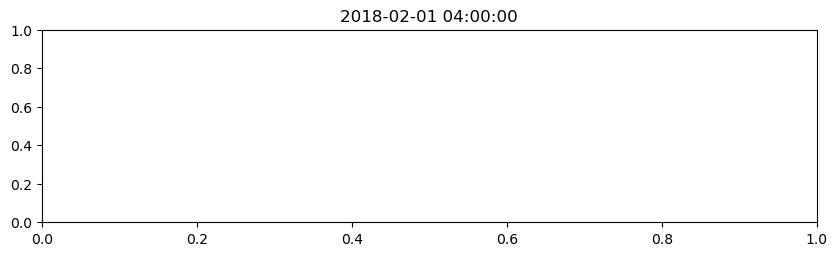

In [8]:
yearday = 30

params_ = {'method': 'ffc_fc',
           'forget_rate': 50,
           'update_rate': 1000,
           'prob': 0.9,
           'unform': False,
           'length_scale': 30,
           'smoothing': 0,
           'lamdba': 0}

for interval in range(48, 288, 24):

    F_tr_, F_ts_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_ = _test_sample(ac_tr_, ac_ts_, fc_ts_, dates_ts_,
                                                                              i_day   = yearday, 
                                                                              t_event = interval,
                                                                              viz     = False)

    if params_['method'] == 'ffc':
        f_ts_hat_, S_ts_hat_, F_ts_scen_ = _ffc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                 forget_rate  = params_['forget_rate'], 
                                                 update_rate  = params_['update_rate'], 
                                                 length_scale = params_['length_scale'],
                                                 smoothing    = params_['smoothing'],
                                                 lamdba       = params_['lamdba'],
                                                 viz          = False)

    if params_['method'] == 'fknn_fc':
        f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                    forget_rate  = params_['forget_rate'], 
                                                    update_rate  = params_['update_rate'], 
                                                    prob     = params_['prob'],
                                                    uniform      = params_['uniform'],
                                                    length_scale = params_['length_scale'],
                                                    smoothing    = params_['smoothing'],
                                                    lamdba       = params_['lamdba'],
                                                    viz          = False)
    print(f_ts_hat_.shape, S_ts_hat_.shape, F_ts_scen_.shape)
    _plot_results(F_tr_, F_ts_scen_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_, dates_ts_, 
                  i_day   = yearday, 
                  t_event = interval)

In [9]:
def _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, interval_, horizon_, params_, verbose = True):
    
    if verbose: print(horizon_, interval_)
    
    f_ts_hat_all_ = [[] for horizon in range(horizon_[0])]
    s_ts_hat_all_ = [[] for horizon in range(horizon_[0])]
    f_ts_all_     = [[] for horizon in range(horizon_[0])]

    for yearday in range(363):
        for interval in range(4, 24, 4):
            interval *= 12
            F_tr_, F_ts_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_ = _test_sample(ac_tr_, ac_ts_, fc_ts_, dates_ts_,
                                                                                      i_day   = yearday, 
                                                                                      t_event = interval,
                                                                                      viz     = False)
            
            if params_['method'] == 'ffc':
                f_ts_hat_, S_ts_hat_, F_ts_scen_ = _ffc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                         forget_rate  = params_['forget_rate'], 
                                                         update_rate  = params_['update_rate'], 
                                                         length_scale = params_['length_scale'],
                                                         smoothing    = params_['smoothing'],
                                                         lamdba       = params_['lamdba'],
                                                         viz          = False)
            
            if params_['method'] == 'fknn_fc':
                f_ts_hat_, S_ts_hat_, F_ts_scen_ = _fknn_fc(F_tr_, f_tr_, F_ts_, fct_ts_,
                                                            forget_rate  = params_['forget_rate'], 
                                                            update_rate  = params_['update_rate'], 
                                                            prob         = params_['prob'],
                                                            length_scale = params_['length_scale'],
                                                            smoothing    = params_['smoothing'],
                                                            lamdba       = params_['lamdba'],
                                                            viz          = False)

            s_ts_hat_ = np.sqrt(np.diagonal(S_ts_hat_))
            
            # idx_ = s_ts_hat_ == 0.
            # if idx_.sum() > 0.:
            #     print(yearday)
            for horizon in range(horizon_[0]):
                h0  = horizon
                h0 *= 12
                h0 *= horizon_[1]
                
                h1  = horizon + 1
                h1 *= 12
                h1 *= horizon_[1]

                if h1 > s_ts_hat_.shape[0]:
                    continue
                else:
                    f_ts_hat_all_[horizon].append(f_ts_hat_[h0:h1])
                    s_ts_hat_all_[horizon].append(s_ts_hat_[h0:h1])
                    f_ts_all_[horizon].append(f_ts_[h0:h1])
    
    f_ts_hat_ = [np.concatenate(f_ts_hat_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    s_ts_hat_ = [np.concatenate(s_ts_hat_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    f_ts_     = [np.concatenate(f_ts_all_[horizon], axis = 0) for horizon in range(horizon_[0])]
    return f_ts_, f_ts_hat_, s_ts_hat_


def _PIT(y_true, forecast_mean, forecast_std, nbins = 30):
    """
    Calculate the Probabilistic Integral Transform (PIT).
    
    Parameters:
    - y_true: Observed (true) values
    - forecast_mean: Mean of the predicted distribution (e.g., mean of the normal distribution)
    - forecast_std: Standard deviation of the predicted distribution
    
    Returns:
    - mean and std: The calculated PIT
    """
            
    u_samples = norm.cdf(y_true, loc = forecast_mean, scale = forecast_std)
    
    # Plot the histogram of U to check if it's uniformly distributed
    plt.figure(figsize = (12.5, 2.5))
    plt.hist(u_samples, bins    = nbins, 
                        density = True, 
                        alpha   = 0.7, 
                        color   = 'blue', 
                        label   = 'Transformed (U)')
    
    plt.hlines(1, 0, 1, color     = 'red', 
                        linestyle = '--', 
                        label     = 'Uniform distribution')
    
    plt.title('Probabilistic Integral Transform')
    plt.xlabel('U')
    plt.ylabel('PDF')
    plt.legend()
    plt.show()

[4, 4] [4, 20]
4
(87120,)


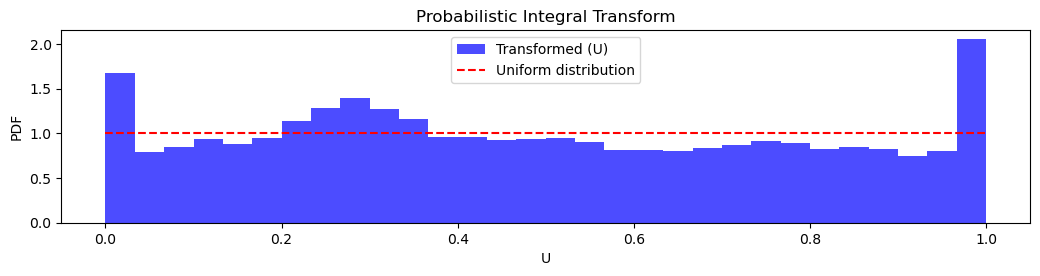

(69696,)


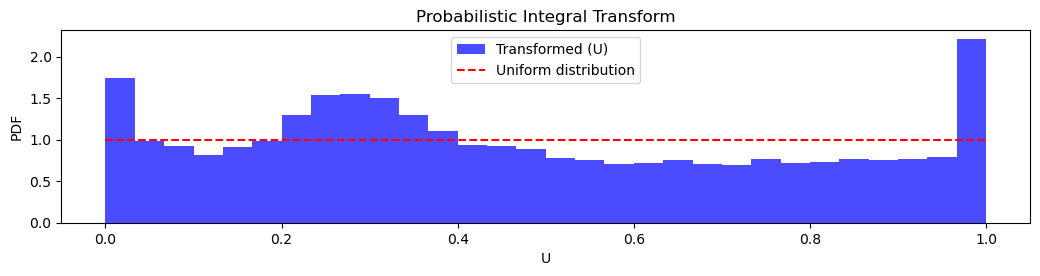

(52272,)


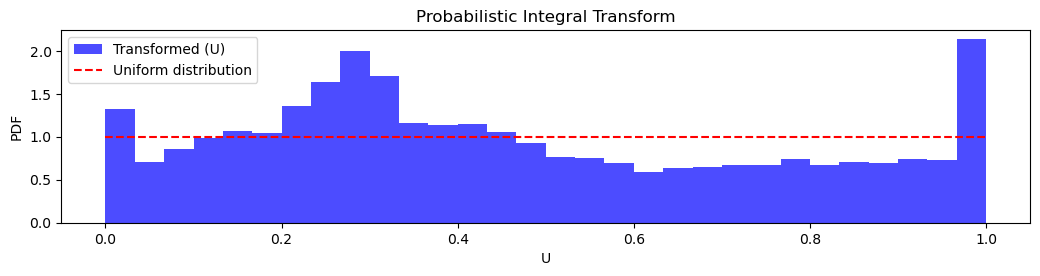

(34848,)


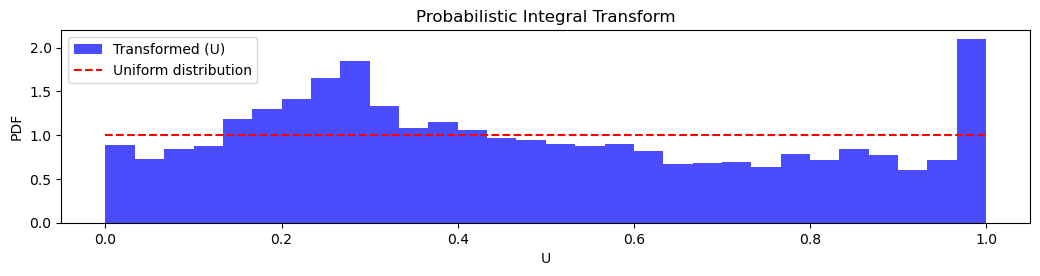

In [16]:
params_ = {'method': 'fknn_fc',
           'forget_rate': 100,
           'update_rate': 1000,
           'length_scale': 100,
           'prob': 0.9,
           'smoothing': 0,
           'lamdba': 0}

horizon_  = [4, 4]
interval_ = [4, 20]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, interval_, horizon_, params_)
print(len(f_ts_))
for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])


In [ ]:
params_ = {'method': 'fknn_fc',
           'forget_rate': 100,
           'update_rate': 10000000,
           'length_scale': 300,
           'prob': 0.9,
           'smoothing': 0,
           'lamdba': 0}

horizon_  = [4, 1]
interval_ = [4, 20]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, interval_, horizon_, params_)

for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])


In [ ]:
params_ = {'method': 'fknn_fc',
           'forget_rate': 10,
           'update_rate': 1000,
           'length_scale': 100,
           'prob': 0.9,
           'smoothing': 0,
           'lamdba': 0}

horizon_  = [4, 1]
interval_ = [4, 20]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, interval_, horizon_, params_)

for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])


In [ ]:
params_ = {'method': 'fknn_fc',
           'forget_rate': 100,
           'update_rate': 100,
           'length_scale': 100,
           'prob': 0.9,
           'smoothing': 0,
           'lamdba': 0}

horizon_  = [4, 1]
interval_ = [4, 20]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, interval_, horizon_, params_)

for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])


In [ ]:
params_ = {'method': 'fknn_fc',
           'forget_rate': 100,
           'update_rate': 10,
           'length_scale': 100,
           'prob': 0.9,
           'smoothing': 0,
           'lamdba': 0}

horizon_  = [4, 1]
interval_ = [4, 20]

f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, interval_, horizon_, params_)

for horion in range(len(f_ts_)):
    print(f_ts_[horion].shape)
    _PIT(f_ts_[horion], f_ts_hat_[horion], s_ts_hat_[horion])


[0, 90] [4, 24]
        RMSE        MAE       MBE
0  45.232622  33.953109  3.801797
           LogS          CRPS
0  6.981887e+08  1.588632e+06


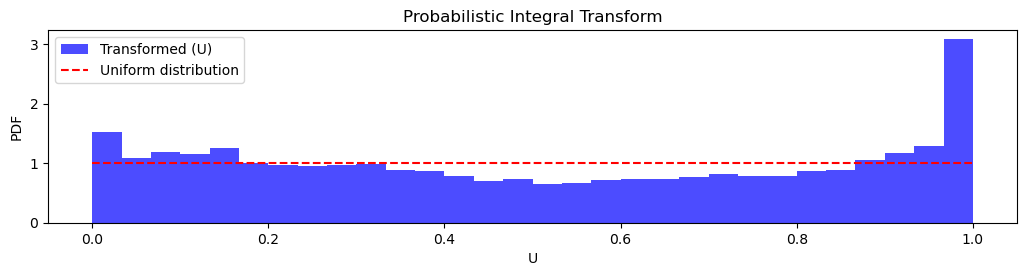

[90, 180] [4, 24]
        RMSE        MAE       MBE
0  36.255987  27.438633  4.848955
           LogS          CRPS
0  1.184703e+06  1.264826e+06


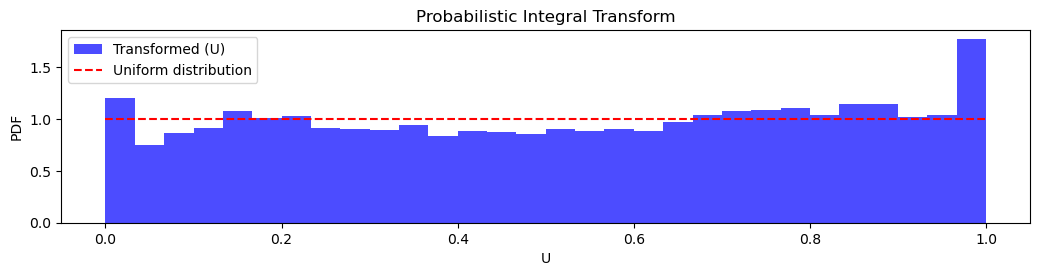

[180, 270] [4, 24]
        RMSE        MAE       MBE
0  27.708748  21.036867 -0.330433
            LogS           CRPS
0  303490.089092  954136.920496


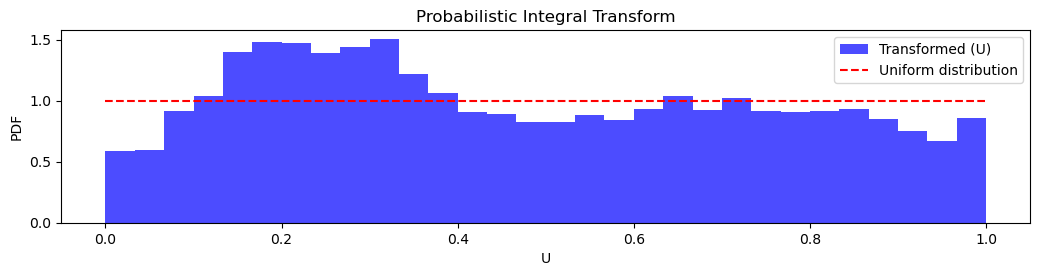

[270, 360] [4, 24]
        RMSE        MAE       MBE
0  38.782934  27.068124 -1.541333
           LogS          CRPS
0  5.786418e+20  1.282296e+06


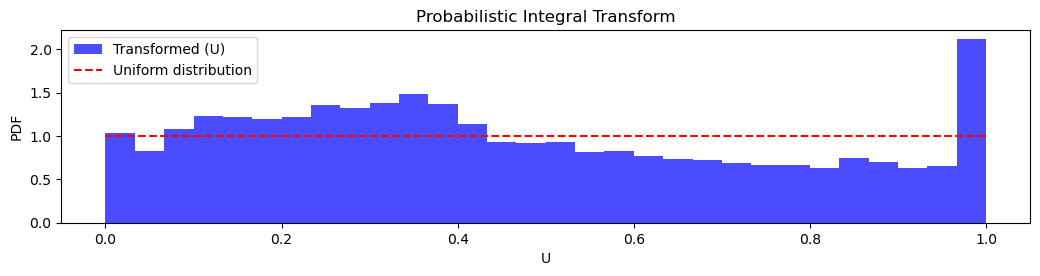

In [291]:
# yearday_  = [0, 90]
# interval_ = [4, 24]
# f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)

# _errors(f_ts_, f_ts_hat_)
# #_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
# #_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _pit(f_ts_, f_ts_hat_, s_ts_hat_)

# yearday_  = [90, 180]
# interval_ = [4, 24]
# f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)

# _errors(f_ts_, f_ts_hat_)
# #_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
# #_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _pit(f_ts_, f_ts_hat_, s_ts_hat_)

# yearday_  = [180, 270]
# interval_ = [4, 24]
# f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)
# _errors(f_ts_, f_ts_hat_)
# #_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
# #_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _pit(f_ts_, f_ts_hat_, s_ts_hat_)

# yearday_  = [270, 360]
# interval_ = [4, 24]
# f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)
# _errors(f_ts_, f_ts_hat_)
# #_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
# #_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
# _pit(f_ts_, f_ts_hat_, s_ts_hat_)

[0, 363] [4, 12]
        RMSE        MAE       MBE
0  39.391283  29.353767  0.248299
           LogS          CRPS
0  1.714369e+06  3.305052e+06


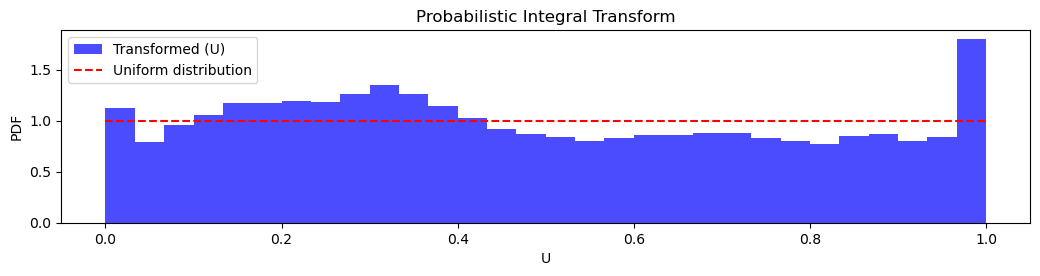

[0, 363] [12, 16]
        RMSE        MAE       MBE
0  37.929991  27.281089  2.928045
           LogS          CRPS
0  5.786418e+20  1.021133e+06


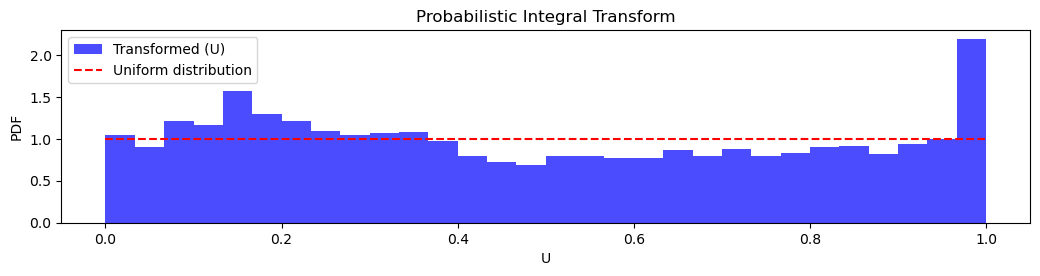

[0, 363] [16, 20]
       RMSE        MAE       MBE
0  33.84413  24.302139  5.215663
           LogS          CRPS
0  8.808523e+08  607066.73704


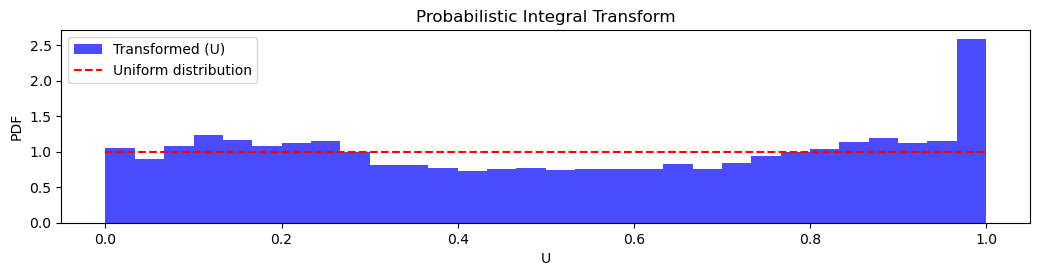

[0, 363] [20, 24]
        RMSE        MAE       MBE
0  22.070402  15.451676  3.193771
           LogS           CRPS
0  94987.134958  193187.636954


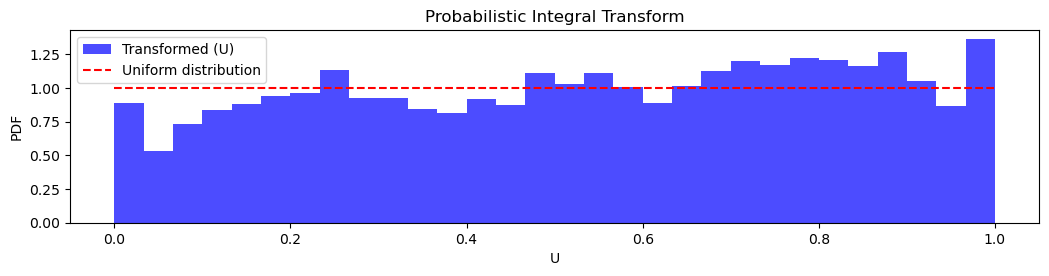

In [292]:
yearday_  = [0, 363]
interval_ = [4, 12]
f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)
_errors(f_ts_, f_ts_hat_)
#_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
#_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_pit(f_ts_, f_ts_hat_, s_ts_hat_)

yearday_  = [0, 363]
interval_ = [12, 16]
f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)
_errors(f_ts_, f_ts_hat_)
#_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
#_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_pit(f_ts_, f_ts_hat_, s_ts_hat_)

yearday_  = [0, 363]
interval_ = [16, 20]
f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)
_errors(f_ts_, f_ts_hat_)
#_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
#_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_pit(f_ts_, f_ts_hat_, s_ts_hat_)

yearday_  = [0, 363]
interval_ = [20, 24]
f_ts_, f_ts_hat_, s_ts_hat_ = _exp(ac_tr_, ac_ts_, fc_ts_, dates_ts_, yearday_, interval_, params_)
_errors(f_ts_, f_ts_hat_)
#_coverages(f_ts_, f_ts_hat_, s_ts_hat_)
#_ignorance_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_proper_scores(f_ts_, f_ts_hat_, s_ts_hat_)
_pit(f_ts_, f_ts_hat_, s_ts_hat_)

In [ ]:
# Interative vizualiation widget
def _viz(yearday, interval):
    
    F_tr_, F_ts_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_tr_, t_ts_ = _test_sample(ac_tr_, ac_ts_, fc_ts_, 
                                                                              i_day   = yearday, 
                                                                              t_event = interval,
                                                                              viz     = False)
    f_ts_hat_, S_ts_hat_, F_ts_scen_ = _ffc(F_tr_, f_tr_, F_ts_, 
                                            forget_rate  = 1, 
                                            update_rate  = 0, 
                                            length_scale = 10,
                                            lamdba       = 0,
                                            N_scen       = 100, 
                                            viz          = False)
    
    _plot_results(F_tr_, F_ts_scen_, S_ts_hat_, f_ts_hat_, f_tr_, f_ts_, fct_tr_, fct_ts_, t_ts_, t_tr_)
    
interact(_viz, yearday = (0, 362, 1), interval = (12, 276, 12))